<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/EfficientNetKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pillow

In [3]:
!pip install cloud_tpu_client

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights=None)
import PIL.Image
import pathlib


In [5]:
from cloud_tpu_client import Client
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [6]:
batch_size = 4
IMG_SIZE = 240
original_dataset_dir = 'drive/MyDrive/mri_images/train'

In [7]:
data_dir = pathlib.Path(original_dataset_dir)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 510 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)


['0', '1', '2']


In [11]:
#size = (IMG_SIZE, IMG_SIZE)
#train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
print(len(train_ds))
#val_ds = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))
print(len(val_ds))

511
128


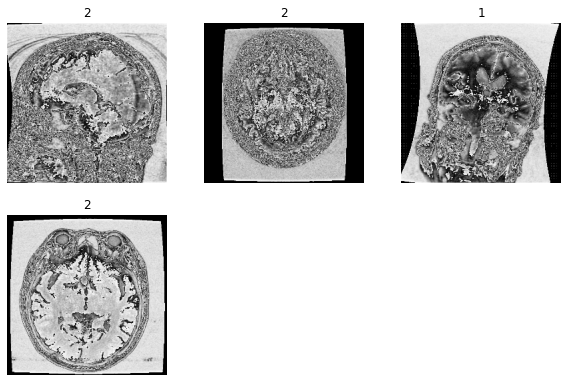

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 240, 240, 3)
(4,)


In [14]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [15]:
#image = tf.expand_dims(image, 0)

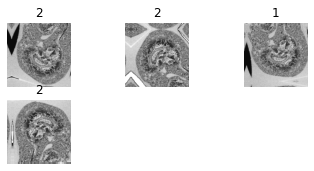

In [16]:
for image, label in train_ds.take(1):
    for i in range(4):
        aug_img = img_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


#train_ds = train_ds.map(
#    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
#)
#print(len(train_ds))
#train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
#train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

#val_ds = val_ds.map(input_preprocess)
#val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)
print(len(train_ds))
print(len(val_ds))

511
128


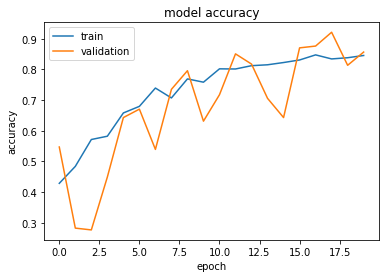

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [19]:

print(len(train_ds))
print(len(val_ds))
with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    print(inputs)
    x = img_augmentation(inputs)
    print(x)
    outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 20  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

511
128
KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), name='img_augmentation/random_contrast/adjust_contrast/Identity:0', description="created by layer 'img_augmentation'")
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0

NameError: ignored

In [22]:
from tensorflow.keras.layers.experimental import preprocessing

In [23]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Epoch 1/20
511/511 - 38s - loss: 1.7820 - accuracy: 0.7561 - val_loss: 2.6146 - val_accuracy: 0.7157
Epoch 2/20
511/511 - 25s - loss: 2.2120 - accuracy: 0.7576 - val_loss: 2.5052 - val_accuracy: 0.7627
Epoch 3/20
511/511 - 25s - loss: 1.9146 - accuracy: 0.7757 - val_loss: 1.3299 - val_accuracy: 0.8431
Epoch 4/20
511/511 - 25s - loss: 1.8714 - accuracy: 0.7713 - val_loss: 1.8048 - val_accuracy: 0.7451
Epoch 5/20
511/511 - 25s - loss: 1.5761 - accuracy: 0.7728 - val_loss: 1.2448 - val_accuracy: 0.7784
Epoch 6/20
511/511 - 25s - loss: 1.3783 - accuracy: 0.7679 - val_loss: 1.2493 - val_accuracy: 0.7490
Epoch 7/20
511/511 - 25s - loss: 1.0512 - accuracy: 0.7889 - val_loss: 0.5444 - val_accuracy: 0.8627
Epoch 8/20
511/511 - 25s - loss: 0.9152 - accuracy: 0.7850 - val_loss: 1.2587 - val_accuracy: 0.7118
Epoch 9/20
511/511 - 25s - loss: 0.8536 - accuracy: 0.7840 - val_loss: 0.6327 - val_accuracy: 0.8078
Epoch 10/20
511/511 - 25s - loss: 0.7070 - accuracy: 0.7987 - val_loss: 0.8149 - val_accura

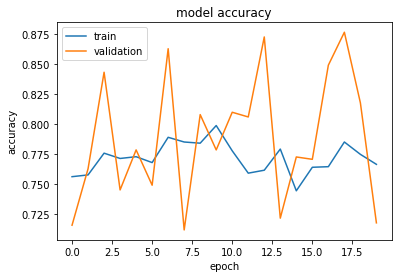

In [28]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 20  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

Epoch 1/20
511/511 - 38s - loss: 0.5806 - accuracy: 0.7929 - val_loss: 0.4089 - val_accuracy: 0.8765
Epoch 2/20
511/511 - 26s - loss: 0.4731 - accuracy: 0.8306 - val_loss: 0.3141 - val_accuracy: 0.9000
Epoch 3/20
511/511 - 26s - loss: 0.4734 - accuracy: 0.8315 - val_loss: 0.4496 - val_accuracy: 0.8588
Epoch 4/20
